<a href="https://colab.research.google.com/github/abigailibarrola/data301-figure-skating/blob/master/DATA_301_Final_Project_Machine_Learning_Abigail_Ibarrola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning: Predicting Individual Judge Scores of Skaters in the Singles Disciplines

The goal of the machine learning portion of this project is to predict an individual judge's score for a skater's competition. Since score is a quantitative value, I will be using regression models to predict scores.

In the data collection portion of this project, I reorganized the main skater data so that a single observation contains one judge's data (instead of all nine in the original). This is what will be used to train and test models.

As explained earlier, I will be only using data whose judge scores are associated with their identity.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from itertools import combinations
from google.colab import drive

In [26]:
# Read in dataset
drive.mount('/content/gdrive')
data_dir = "/content/gdrive/My Drive/DATA 301/"

df_skaters_ml = pd.read_csv(data_dir + "skaters_data_ml.csv")
df_skaters_ml

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,comp_id,skater_fullname,skater_nat,gender,bv,num_quads,num_triples,num_doubles,num_jump_errors,num_spin_errors,judge_nat,judge_tes,judge_pcs,judge_total
0,WC_1617,Evgenia MEDVEDEVA,RUS,F,33.10,0,3,1,0,0,FRA,40.30,37.0,77.30
1,WC_1617,Kaetlyn OSMOND,CAN,F,32.53,0,3,1,0,0,FRA,39.53,32.8,72.33
2,WC_1617,Gabrielle DALEMAN,CAN,F,31.83,0,3,1,0,0,FRA,38.33,32.2,70.53
3,WC_1617,Anna POGORILAYA,RUS,F,32.84,0,3,1,0,0,FRA,36.24,33.8,70.04
4,WC_1617,Karen CHEN,USA,F,32.24,0,3,1,0,0,FRA,38.84,30.4,69.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22696,GPCAN_1920,Roman SADOVSKY,CAN,M,69.47,2,6,0,4,0,LAT,64.90,78.5,143.40
22697,GPCAN_1920,Brendan KERRY,AUS,M,63.95,1,5,3,0,0,LAT,68.57,71.5,140.07
22698,GPCAN_1920,Julian Zhi Jie YEE,MAS,M,57.63,0,6,4,1,0,LAT,61.20,72.0,133.20
22699,GPCAN_1920,Paul FENTZ,GER,M,62.05,0,7,3,1,0,LAT,63.05,72.0,135.05


## Pulling out test data

My original plan was to predict scores for the top 10 skaters for the Men and Ladies disciplines for the ISU World Figure Skating Championships, originally planned to begin on March 16, 2020. But due to the COVID-19 pandemic of this time, this event was cancelled.

To compensate, I pulled out a portion of my current machine learning data to be used as test data. I chose 10 male and female skaters who are relatively ranked highly in the current worlds standings, who represent countries with solid histories in figure skating, and have had a recent international competition during the 2019-2020 season. I pulled out each skater's most recent competition data.

In [3]:
# Segment out test data
test_skaters = [
    ["Nathan CHEN", "GPF_1920"],
    ["Yuzuru HANYU", "4CC_1920"],
    ["Shoma UNO", "GPRUS_1920"],
    ["Dmitri ALIEV", "EC_1920"],
    ["Keegan MESSING", "4CC_1920"],
    ["Jason BROWN", "4CC_1920"],
    ["Alexander SAMARIN", "EC_1920"],
    ["Matteo RIZZO", "EC_1920"],
    ["Boyang JIN", "4CC_1920"],
    ["Junhwan CHA", "4CC_1920"],
    ["Rika KIHIRA", "4CC_1920"],
    ["Alina ZAGITOVA", "GPF_1920"],
    ["Satoko MIYAHARA", "GPRUS_1920"],
    ["Bradie TENNEL", "4CC_1920"],
    ["Evgenia MEDVEDEVA", "GPRUS_1920"],
    ["Kaori SAKAMOTO", "4CC_1920"],
    ["Alena KOSTORNAIA", "EC_1920"],
    ["Mariah BELL", "GPRUS_1920"],
    ["Young YOU", "4CC_1920"],
    ["Eunsoo LIM", "4CC_1920"]
]

test_skaters_data = []

for skater in test_skaters:
  mask = ((df_skaters_ml["skater_fullname"] == skater[0]) &
         (df_skaters_ml["comp_id"] == skater[1]))
  skater_data = df_skaters_ml.loc[mask].copy()
  df_skaters_ml = df_skaters_ml[~mask]
  test_skaters_data.append(skater_data)

df_skaters_test = pd.concat(test_skaters_data)
df_skaters_test.reset_index(drop=True, inplace=True)
df_skaters_test

,comp_id,skater_fullname,skater_nat,gender,bv,num_quads,num_triples,num_doubles,num_jump_errors,num_spin_errors,judge_nat,judge_tes,judge_pcs,judge_total
0,GPF_1920,Nathan CHEN,USA,M,48.17,2,2,0,0,0,FRA,64.03,47.25,111.28
1,GPF_1920,Nathan CHEN,USA,M,97.73,5,5,0,0,0,FRA,131.02,96.00,227.02
2,GPF_1920,Nathan CHEN,USA,M,48.17,2,2,0,0,0,CHN,62.84,47.25,110.09
3,GPF_1920,Nathan CHEN,USA,M,97.73,5,5,0,0,0,CHN,134.22,96.50,230.72
4,GPF_1920,Nathan CHEN,USA,M,48.17,2,2,0,0,0,AUT,59.79,46.50,106.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,4CC_1920,Eunsoo LIM,KOR,F,56.36,0,6,5,1,0,MEX,66.93,67.20,134.13
330,4CC_1920,Eunsoo LIM,KOR,F,28.83,0,2,2,0,0,CHN,33.95,32.00,65.95
331,4CC_1920,Eunsoo LIM,KOR,F,56.36,0,6,5,1,0,JPN,65.27,66.40,131.67
332,4CC_1920,Eunsoo LIM,KOR,F,28.83,0,2,2,0,0,KAZ,36.87,33.00,69.87


In [4]:
df_skaters_ml

,comp_id,skater_fullname,skater_nat,gender,bv,num_quads,num_triples,num_doubles,num_jump_errors,num_spin_errors,judge_nat,judge_tes,judge_pcs,judge_total
0,WC_1617,Evgenia MEDVEDEVA,RUS,F,33.10,0,3,1,0,0,FRA,40.30,37.0,77.30
1,WC_1617,Kaetlyn OSMOND,CAN,F,32.53,0,3,1,0,0,FRA,39.53,32.8,72.33
2,WC_1617,Gabrielle DALEMAN,CAN,F,31.83,0,3,1,0,0,FRA,38.33,32.2,70.53
3,WC_1617,Anna POGORILAYA,RUS,F,32.84,0,3,1,0,0,FRA,36.24,33.8,70.04
4,WC_1617,Karen CHEN,USA,F,32.24,0,3,1,0,0,FRA,38.84,30.4,69.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22696,GPCAN_1920,Roman SADOVSKY,CAN,M,69.47,2,6,0,4,0,LAT,64.90,78.5,143.40
22697,GPCAN_1920,Brendan KERRY,AUS,M,63.95,1,5,3,0,0,LAT,68.57,71.5,140.07
22698,GPCAN_1920,Julian Zhi Jie YEE,MAS,M,57.63,0,6,4,1,0,LAT,61.20,72.0,133.20
22699,GPCAN_1920,Paul FENTZ,GER,M,62.05,0,7,3,1,0,LAT,63.05,72.0,135.05


# Predicting Total Score by Judge

The primary features I will be using in this model includes the skater's name, skater's nationality, judge's nationality, skater's performance BV, and their gender.

Other features that will be considered include the number of quad, triple, and double jumps performed, the number of jump errors, and the number of spin errors. I will be exploring combinations of these other features with primary features to see which set creates the best model.

In [0]:
features = list(df_skaters_ml.columns.drop(["comp_id", "judge_total", "judge_tes", "judge_pcs"]))
cat_vars = ['skater_fullname', 'skater_nat', 'gender', 'judge_nat']
quant_vars = [f for f in features if f not in cat_vars]
base_features = cat_vars + ['bv']
misc_features = quant_vars.copy()
misc_features.remove('bv')

y_train = df_skaters_ml["judge_total"]

## K-Nearest Neighbors

### Finding the best k for K-Nearest Neighbors

In [6]:
X_train = df_skaters_ml[features]

# Column transformer for specified features
ct = make_column_transformer(
    (StandardScaler(), quant_vars),
    (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    remainder="passthrough"
)

pipeline = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=20, metric="euclidean")
)

clf = GridSearchCV(pipeline,
                   param_grid={
                       "kneighborsregressor__n_neighbors": range(1, 20)
                       },
                   scoring="neg_mean_squared_error",
                   cv=10)
clf.fit(X_train, y_train)
clf.best_estimator_

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['bv', 'num_quads',
                                                   'num_triples', 'num_doubles',
                                                   'num_jump_errors',
                                                   'num_spin_errors']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categories='auto',


8    4.187033
9    4.211005
dtype: float64

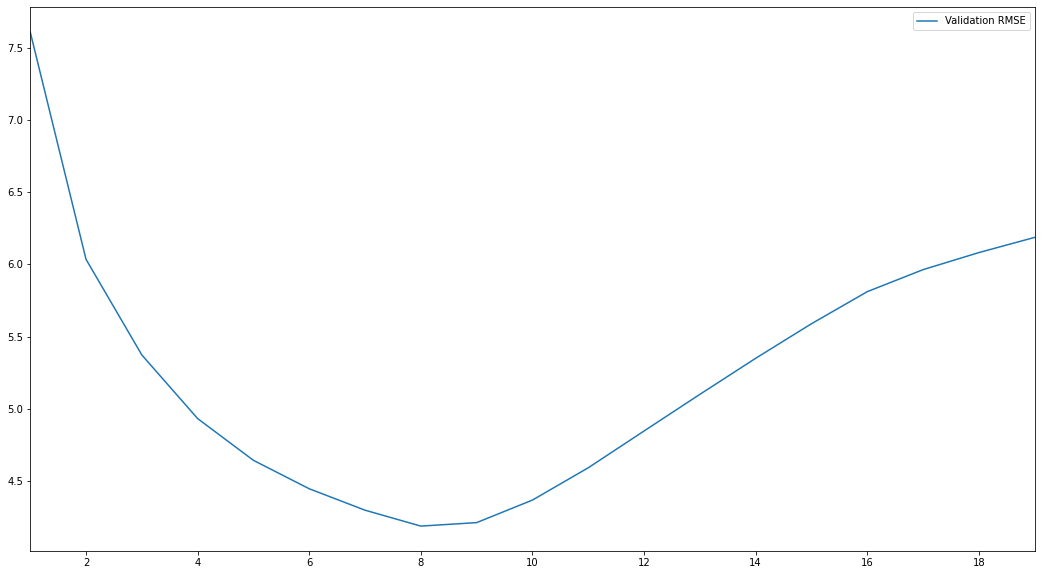

In [8]:
results = clf.cv_results_

# Get a series containing the RMSE for each k
cv_rmse = pd.Series(
            np.sqrt(-results["mean_test_score"]),
            index=results["param_kneighborsregressor__n_neighbors"]
            )

cv_rmse.plot.line(legend=True, label="Validation RMSE", figsize=(18, 10), title="Validation RMSE vs K")
cv_rmse.sort_values().head(2)

It appears that **k=8** yields the best validation RSME error. 

### Exploring different features

In [0]:
misc_feat_combos = [[]]

# Get all combinations of features
for r in range(1, len(misc_features) + 1):
  misc_feat_combos.extend(list(combinations(misc_features, r)))

# Convert all into list of list of features
for i in range(len(misc_feat_combos)):
  misc_feat_combos[i] = list(misc_feat_combos[i])

In [0]:
def try_diff_features(model):
  rmse_series = pd.Series()

  for feat_combo in misc_feat_combos:
    ct = make_column_transformer(
        (StandardScaler(), ['bv'] + feat_combo),
        (OneHotEncoder(handle_unknown="ignore"), cat_vars),
        remainder="passthrough"
    )

    pipeline = make_pipeline(ct, model)
    train_features = base_features + feat_combo
    cv_errs = -cross_val_score(pipeline, 
                                X=df_skaters_ml[train_features],
                                y=y_train,
                                scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(cv_errs.mean())
    rmse_series[str(feat_combo)] = rmse
    
  return rmse_series

In [11]:
knearest_rmse_misc = try_diff_features(KNeighborsRegressor(n_neighbors=8, metric="euclidean"))
knearest_rmse_misc.sort_values()

['num_quads', 'num_triples', 'num_doubles', 'num_jump_errors', 'num_spin_errors']    4.187033
['num_quads', 'num_triples', 'num_doubles', 'num_jump_errors']                       4.258439
['num_triples', 'num_doubles', 'num_jump_errors', 'num_spin_errors']                 4.334700
['num_triples', 'num_doubles', 'num_jump_errors']                                    4.435239
['num_quads', 'num_doubles', 'num_jump_errors', 'num_spin_errors']                   4.534056
['num_quads', 'num_doubles', 'num_jump_errors']                                      4.629450
['num_quads', 'num_triples', 'num_jump_errors', 'num_spin_errors']                   4.629729
['num_quads', 'num_triples', 'num_doubles', 'num_spin_errors']                       4.696675
['num_doubles', 'num_jump_errors', 'num_spin_errors']                                4.735404
['num_quads', 'num_triples', 'num_jump_errors']                                      4.815129
['num_quads', 'num_triples', 'num_doubles']                 

It looks like using all primary features and all other features together yielded the best results.

The best Validation RMSE value for K-Nearest Neighbors is **4.187033**.

Now onto keeping track of the model to be used later.

In [0]:
# Keep track of model
models = {
    "Model Name" : [],
    "Validation RSME" : [],
    "Test RSME" : [],
    "Features" : [],
    "Model" : []
}

ct = make_column_transformer(
    (StandardScaler(), quant_vars),
    (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    remainder="passthrough"
)

best_knearest = make_pipeline(
    ct,
    KNeighborsRegressor(n_neighbors=8, metric="euclidean")
)

models["Model Name"].append("KNearestNeighbors")
models["Validation RSME"].append(knearest_rmse_misc.min())
models["Features"].append(features)
models["Model"].append(best_knearest)

## Linear Regression



### Testing different scalers for quantitative values

In [13]:
def get_ct_by_scaler(scaler):
  return make_column_transformer(
    (scaler, quant_vars),
    (OneHotEncoder(handle_unknown="ignore"), cat_vars),
    remainder="passthrough"
)

all_cts = {
    "StandardScaler" : get_ct_by_scaler(StandardScaler()), 
    "Normalizer" : get_ct_by_scaler(Normalizer()), 
    "MinMaxScaler" : get_ct_by_scaler(MinMaxScaler()), 
    "MaxAbsScaler" : get_ct_by_scaler(MaxAbsScaler())
    }

linear_rmse = pd.Series()

for key in all_cts.keys():
  pipeline = make_pipeline(
      all_cts[key],
      LinearRegression()
  )

  cv_errs = -cross_val_score(pipeline, 
                            X=X_train,
                            y=y_train,
                            scoring="neg_mean_squared_error", cv=10)
  rmse = np.sqrt(cv_errs.mean())
  linear_rmse[key] = rmse

linear_rmse

StandardScaler     6.891641
Normalizer        17.888373
MinMaxScaler       6.891641
MaxAbsScaler       6.891641
dtype: float64

It looks like only Normalizing the quantitative values had any real effect on the performance of the model. I will be using Standardization for the rest of my models.

### Exploring different features

In [14]:
linear_rmse_misc = try_diff_features(LinearRegression())
linear_rmse_misc.sort_values()

['num_quads', 'num_triples', 'num_doubles', 'num_jump_errors', 'num_spin_errors']    6.891641
['num_triples', 'num_doubles', 'num_jump_errors', 'num_spin_errors']                 6.891739
['num_quads', 'num_triples', 'num_doubles', 'num_jump_errors']                       6.895256
['num_triples', 'num_doubles', 'num_jump_errors']                                    6.895595
['num_quads', 'num_triples', 'num_doubles', 'num_spin_errors']                       6.908156
['num_quads', 'num_triples', 'num_doubles']                                          6.911791
['num_triples', 'num_doubles', 'num_spin_errors']                                    6.913205
['num_triples', 'num_doubles']                                                       6.915993
['num_quads', 'num_doubles', 'num_jump_errors', 'num_spin_errors']                   6.949740
['num_quads', 'num_doubles', 'num_spin_errors']                                      6.950414
['num_quads', 'num_doubles', 'num_jump_errors']             

Again, it looks like using all primary and other features together yielded the best results.

The best Validation RMSE value for Linear Regressor is **6.891641**, more than 50% increase from K-Neighbors Regressor's RMSE.

Now onto recording this model to be used later.

In [0]:
best_linear = make_pipeline(
      get_ct_by_scaler(StandardScaler()),
      LinearRegression()
)

models["Model Name"].append("LinearRegression")
models["Validation RSME"].append(linear_rmse_misc.min())
models["Features"].append(features)
models["Model"].append(best_linear)

## Ensemble Models

With the K-Nearest and Linear Regression models found, let's see if we can improve upon them by ensembling them together.

### Voting Ensemble Model

In [0]:
ensemble_model_vote = VotingRegressor([
    ("knn", models["Model"][0]),
    ("linear", models["Model"][1])
])

cv_errs = -cross_val_score(ensemble_model_vote, 
                            X=X_train,
                            y=y_train,
                            scoring="neg_mean_squared_error", cv=10)
ensemble_vote_rmse = np.sqrt(cv_errs.mean())

models["Model Name"].append("EnsembleModel_Voting")
models["Validation RSME"].append(ensemble_vote_rmse)
models["Features"].append(features)
models["Model"].append(ensemble_model_vote)

### Stacking Ensemble Model

In [0]:
ensemble_model_stack = StackingRegressor([
    ("linear", models["Model"][1]), 
    ("knn", models["Model"][0])],
    final_estimator=LinearRegression()
)

cv_errs = -cross_val_score(ensemble_model_stack, 
                            X=X_train,
                            y=y_train,
                            scoring="neg_mean_squared_error", cv=10)
ensemble_stack_rmse = np.sqrt(cv_errs.mean())

models["Model Name"].append("EnsembleModel_Stacking")
models["Validation RSME"].append(ensemble_stack_rmse)
models["Features"].append(features)
models["Model"].append(ensemble_model_stack)

## Model prediction results

Now that we have all models, let's see how well they actually predict the test data.

In [0]:
y_test_total = df_skaters_test["judge_total"]

for i in range(0, len(models["Model Name"])):
  m_features = models["Features"][i]
  X_train = df_skaters_ml[m_features]
  X_test = df_skaters_test[m_features]
  model = models["Model"][i]
  model.fit(X=X_train, y=y_train)
  y_test_ = model.predict(X_test)
  models["Test RSME"].append(np.sqrt(mean_squared_error(y_test_total, y_test_)))

In [19]:
used_models = models["Model"]
del models["Model"], models["Features"]
pd.DataFrame(models)

,Model Name,Validation RSME,Test RSME
0,KNearestNeighbors,4.187033,9.997143
1,LinearRegression,6.891641,9.670533
2,EnsembleModel_Voting,4.872629,8.603258
3,EnsembleModel_Stacking,4.172718,9.691657


It looks like that while the Stacking Ensemble Model had the best estimated test (validation) RSME, the Voting Ensemble Model ended up being the clear best performer for predicting the skaters' scores in the test data set, with the best test RSME of **8.603258**.

One interesting note is that while the LinearRegression model was the odd one out in terms of estimated test error, it actually ended up performing second best behind the Voting Ensemble Model.

Is this a decent RSME? I would say it is not terrible overall. The differences between total scores of skaters can vary between a tenth of a point to an over 20 point difference. Even between judges, it's not uncommon for two judges to have an over 10 point difference in their total scores for the same skater performance. 

# Predicting TES and PCS instead of total score

This is just mostly out of curiosity, since I wasn't sure what would happen, but what if instead of predicting the total score, I predicted the TES scores and PCS scores, summed them together, then used that sum as the predicted value?

Using the same models found, I will predict TES and PCS individually, and see if they any difference over predicting the total score.

## Using models to predict TES

In [0]:
y_test_tes = df_skaters_test["judge_tes"]
y_train_tes = df_skaters_ml["judge_tes"]
tes_predictions = []

tes_models = {
    "Model Name" : models["Model Name"],
    "Validation RSME" : [],
    "Test RSME" : [],
    "Model" : used_models
}

for i in range(0, len(tes_models["Model Name"])):
  X_train = df_skaters_ml[features]
  X_test = df_skaters_test[features]
  model = tes_models["Model"][i]

  # Get Validation Error
  cv_errs = -cross_val_score(model, 
                              X=X_train,
                              y=y_train_tes,
                              scoring="neg_mean_squared_error", cv=10)
  tes_models["Validation RSME"].append(np.sqrt(cv_errs.mean()))
  
  # Get Test Error
  model.fit(X=X_train, y=y_train_tes)
  y_test_ = model.predict(X_test)
  tes_predictions.append(y_test_)
  tes_models["Test RSME"].append(np.sqrt(mean_squared_error(y_test_tes, y_test_)))

In [21]:
del tes_models["Model"]
pd.DataFrame(tes_models)

,Model Name,Validation RSME,Test RSME
0,KNearestNeighbors,2.380917,6.990276
1,LinearRegression,3.458204,5.692886
2,EnsembleModel_Voting,2.593024,5.841868
3,EnsembleModel_Stacking,2.357170,6.680710


## Using models to predict PCS

In [0]:
y_test_pcs = df_skaters_test["judge_pcs"]
y_train_pcs = df_skaters_ml["judge_pcs"]
pcs_predictions = []

pcs_models = {
    "Model Name" : models["Model Name"],
    "Validation RSME" : [],
    "Test RSME" : [],
    "Model" : used_models
}

for i in range(0, len(pcs_models["Model Name"])):
  X_train = df_skaters_ml[features]
  X_test = df_skaters_test[features]
  model = pcs_models["Model"][i]

  # Get Validation Error
  cv_errs = -cross_val_score(model, 
                              X=X_train,
                              y=y_train_pcs,
                              scoring="neg_mean_squared_error", cv=10)
  pcs_models["Validation RSME"].append(np.sqrt(cv_errs.mean()))
  
  # Get Test Error
  model.fit(X=X_train, y=y_train_pcs)
  y_test_ = model.predict(X_test)
  pcs_predictions.append(y_test_)
  pcs_models["Test RSME"].append(np.sqrt(mean_squared_error(y_test_pcs, y_test_)))

In [23]:
del pcs_models["Model"]
pd.DataFrame(pcs_models)

,Model Name,Validation RSME,Test RSME
0,KNearestNeighbors,2.683124,3.976231
1,LinearRegression,4.992629,5.424526
2,EnsembleModel_Voting,3.370140,4.054593
3,EnsembleModel_Stacking,2.682848,3.969759


## Combined prediction results

In [24]:
total_pred_rmse = []

for i in range(0, len(tes_predictions)):
  total_pred = tes_predictions[i] + pcs_predictions[i]
  total_pred_rmse.append(np.sqrt(mean_squared_error(y_test_total, total_pred)))

pd.DataFrame({"Model Name" : models["Model Name"], "Test RSME" : total_pred_rmse})

,Model Name,Test RSME
0,KNearestNeighbors,9.997143
1,LinearRegression,9.670532
2,EnsembleModel_Voting,8.603257
3,EnsembleModel_Stacking,9.705856


Turns out the Test RSME's using this combined method are almost exactly the same as the Test RSME's found earlier, with a very slight difference for the Stackin Ensemble Method. That's good to know!